In [1]:
#Not all these packages are required but they are here for completeness
import importlib
import io
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw, ImageStat
import SimpleITK as sitk
from skimage import io
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_holes
import staintools
from staintools import stain_normalizer, LuminosityStandardizer, ReinhardColorNormalizer
import sys

Image.MAX_IMAGE_PIXELS = None

In [2]:
print(sys.executable) 

BASE_DIR = Path().resolve()
HEMNET_DIR = BASE_DIR.parent.joinpath('HEMnet')

sys.path.append(str(HEMNET_DIR))

from slide import *
from utils import *

/gpfs1/scratch/90days/s4436005/envs/bin/python


In [3]:
SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides')
HE_JPEGS_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides/jpegs/HandE_2x')
HE_NORM_JPEGS_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides/normalised/vahadane_2x')
TEMPLATE_SLIDE_PATH = SLIDES_PATH.joinpath('2171_T_11524A_2_HandE.svs')

MAG = 2

In [10]:
train_slide_prefixes = ['1820_', '2065_', '2112_', '2148_', '2171_']

In [11]:
he_img_names = []
for img in HE_JPEGS_PATH.glob('*.jpeg'):
    name = img.name
    he_img_names.append(name)
he_img_names.sort()
he_img_names

['1792_T_9500_3_HandE_2x.jpeg',
 '1794_T_9504_3_HandE_2x.jpeg',
 '1798_T_9514_3_HandE_2x.jpeg',
 '1820_N_10545A_2_HandE_2x.jpeg',
 '1820_T_105452F_2_HandE_2x.jpeg',
 '1843_T_9561_3_HandE_2x.jpeg',
 '1879_T_9580_3_HandE_2x.jpeg',
 '1910_T_9637_3_HandE_2x.jpeg',
 '1915_T_10464_3_HandE_2x.jpeg',
 '1919_T_10779_3_HandE_2x.jpeg',
 '1928_T_9644_3_HandE_2x.jpeg',
 '1932_T_9876_3_HandE_2x.jpeg',
 '1939_T_9661_3_HandE_2x.jpeg',
 '1957_T_9668_3_HandE_2x.jpeg',
 '2011_T_9699_3_HandE_2x.jpeg',
 '2019_T_9717_3_HandE_2x.jpeg',
 '2023_T_9727_3_HandE_2x.jpeg',
 '2036_T_9729_3_HandE_2x.jpeg',
 '2038_T_11986_3_HandE_2x.jpeg',
 '2065_N_12752A_2_HandE_2x.jpeg',
 '2065_T_12756A_2_HandE_2x.jpeg',
 '2075_T_9787_3_HandE_2x.jpeg',
 '2090_T_10594_3_HandE_2x.jpeg',
 '2107_T_9806_3_HandE_2x.jpeg',
 '2112_N_12341B_2_HandE_2x.jpeg',
 '2112_T_12335F_2_HandE_2x.jpeg',
 '2148_N_11397A_2_HandE_2x.jpeg',
 '2148_T_11393A_2_HandE_2x.jpeg',
 '2171_N_11521A_2_HandE_2x.jpeg',
 '2171_T_11524A_2_HandE_2x.jpeg',
 '232_T_13230_3

In [12]:
he_norm_img_names = []
for img in HE_NORM_JPEGS_PATH.glob('*.jpeg'):
    name = img.name
    he_norm_img_names.append(name)
he_norm_img_names.sort()
he_norm_img_names

['1792_T_9500_3_HandE_2x.jpeg',
 '1794_T_9504_3_HandE_2x.jpeg',
 '1798_T_9514_3_HandE_2x.jpeg',
 '1820_N_10545A_2_HandE_2x.jpeg',
 '1820_T_105452F_2_HandE_2x.jpeg',
 '1843_T_9561_3_HandE_2x.jpeg',
 '1879_T_9580_3_HandE_2x.jpeg',
 '1910_T_9637_3_HandE_2x.jpeg',
 '1915_T_10464_3_HandE_2x.jpeg',
 '1919_T_10779_3_HandE_2x.jpeg',
 '1928_T_9644_3_HandE_2x.jpeg',
 '1932_T_9876_3_HandE_2x.jpeg',
 '1939_T_9661_3_HandE_2x.jpeg',
 '1957_T_9668_3_HandE_2x.jpeg',
 '2011_T_9699_3_HandE_2x.jpeg',
 '2019_T_9717_3_HandE_2x.jpeg',
 '2023_T_9727_3_HandE_2x.jpeg',
 '2036_T_9729_3_HandE_2x.jpeg',
 '2038_T_11986_3_HandE_2x.jpeg',
 '2065_N_12752A_2_HandE_2x.jpeg',
 '2065_T_12756A_2_HandE_2x.jpeg',
 '2075_T_9787_3_HandE_2x.jpeg',
 '2090_T_10594_3_HandE_2x.jpeg',
 '2107_T_9806_3_HandE_2x.jpeg',
 '2112_N_12341B_2_HandE_2x.jpeg',
 '2112_T_12335F_2_HandE_2x.jpeg',
 '2148_N_11397A_2_HandE_2x.jpeg',
 '2148_T_11393A_2_HandE_2x.jpeg',
 '2171_N_11521A_2_HandE_2x.jpeg',
 '2171_T_11524A_2_HandE_2x.jpeg',
 '232_T_13230_3

In [15]:
imgs_df = pd.DataFrame(list(zip(he_img_names, he_norm_img_names)), columns = ['original','norm'])
imgs_df

,original,norm
0,1792_T_9500_3_HandE_2x.jpeg,1792_T_9500_3_HandE_2x.jpeg
1,1794_T_9504_3_HandE_2x.jpeg,1794_T_9504_3_HandE_2x.jpeg
2,1798_T_9514_3_HandE_2x.jpeg,1798_T_9514_3_HandE_2x.jpeg
3,1820_N_10545A_2_HandE_2x.jpeg,1820_N_10545A_2_HandE_2x.jpeg
4,1820_T_105452F_2_HandE_2x.jpeg,1820_T_105452F_2_HandE_2x.jpeg
5,1843_T_9561_3_HandE_2x.jpeg,1843_T_9561_3_HandE_2x.jpeg
6,1879_T_9580_3_HandE_2x.jpeg,1879_T_9580_3_HandE_2x.jpeg
7,1910_T_9637_3_HandE_2x.jpeg,1910_T_9637_3_HandE_2x.jpeg
8,1915_T_10464_3_HandE_2x.jpeg,1915_T_10464_3_HandE_2x.jpeg
9,1919_T_10779_3_HandE_2x.jpeg,1919_T_10779_3_HandE_2x.jpeg


In [27]:
is_train_slide = lambda x: any([prefix in x for prefix in train_slide_prefixes])

In [37]:
imgs_train_df = imgs_df[imgs_df.original.apply(is_train_slide)]
imgs_train_df

,original,norm
3,1820_N_10545A_2_HandE_2x.jpeg,1820_N_10545A_2_HandE_2x.jpeg
4,1820_T_105452F_2_HandE_2x.jpeg,1820_T_105452F_2_HandE_2x.jpeg
19,2065_N_12752A_2_HandE_2x.jpeg,2065_N_12752A_2_HandE_2x.jpeg
20,2065_T_12756A_2_HandE_2x.jpeg,2065_T_12756A_2_HandE_2x.jpeg
24,2112_N_12341B_2_HandE_2x.jpeg,2112_N_12341B_2_HandE_2x.jpeg
25,2112_T_12335F_2_HandE_2x.jpeg,2112_T_12335F_2_HandE_2x.jpeg
26,2148_N_11397A_2_HandE_2x.jpeg,2148_N_11397A_2_HandE_2x.jpeg
27,2148_T_11393A_2_HandE_2x.jpeg,2148_T_11393A_2_HandE_2x.jpeg
28,2171_N_11521A_2_HandE_2x.jpeg,2171_N_11521A_2_HandE_2x.jpeg
29,2171_T_11524A_2_HandE_2x.jpeg,2171_T_11524A_2_HandE_2x.jpeg


In [86]:
NUM = 0
img_norm_name = imgs_train_df.norm.iloc[NUM]
img_name = imgs_train_df.original.iloc[NUM]
img_norm = io.imread(HE_NORM_JPEGS_PATH.joinpath(img_norm_name))
img = io.imread(HE_JPEGS_PATH.joinpath(img_name))

In [98]:
def plot_histogram(img, axes, yscale = 'linear'):
    axes.hist(img.ravel(), bins = 256, color = 'orange', alpha = 0.5)
    axes.hist(img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    axes.hist(img[:, :, 1].ravel(), bins = 256, color = 'green', alpha = 0.5)
    axes.hist(img[:, :, 2].ravel(), bins = 256, color = 'blue', alpha = 0.5)
    axes.axvline(img.ravel().mean(), color = 'orange')
    axes.axvline(img[:, :, 0].ravel().mean(), color = 'red')
    axes.axvline(img[:, :, 1].ravel().mean(), color = 'green')
    axes.axvline(img[:, :, 2].ravel().mean(), color = 'blue')
    axes.set_xlabel('Intensity Value')
    axes.set_ylabel('Pixel Count')
    axes.legend(['Total_Mean','Red_Mean', 'Green_Mean', 'Blue_Mean', 'Total','Red_Channel', 'Green_Channel', 'Blue_Channel'])
    axes.set_xlim([0, 255])
    axes.set_yscale(yscale)

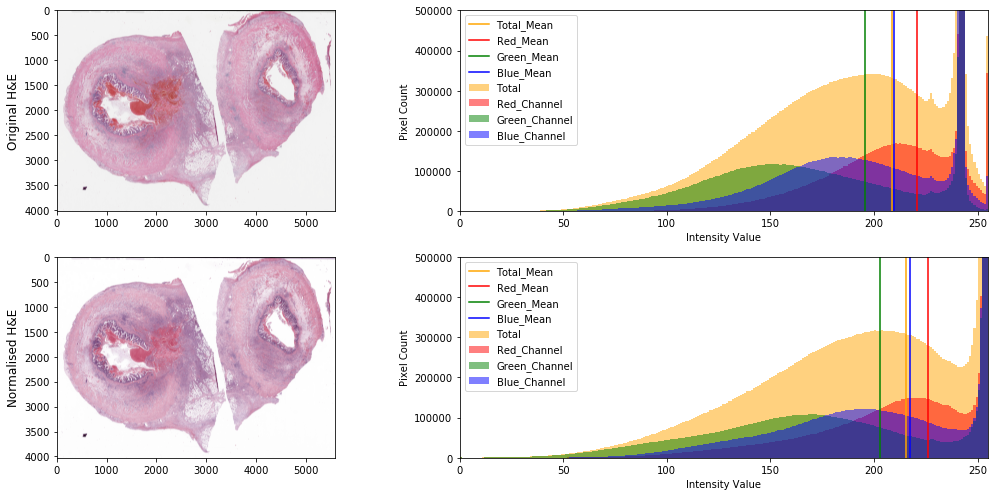

In [102]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,7))
axs[0,0].imshow(img, interpolation = 'bicubic')
plot_histogram(img, axs[0,1])
axs[1,0].imshow(img_norm, interpolation = 'bicubic')
plot_histogram(img_norm, axs[1,1])
#ax.set_ylim([0, 200000])
axs[0,1].set_ylim([0, 500000])
axs[1,1].set_ylim([0, 500000])
axs[0,0].set_ylabel('Original H&E', size = 'large')
axs[1,0].set_ylabel('Normalised H&E', size = 'large')
fig.tight_layout()
plt.show()

In [119]:
def img_means(img):
    means = {}
    means['total'] = img.ravel().mean()
    means['red'] = img[:, :, 0].ravel().mean()
    means['green'] = img[:, :, 1].ravel().mean()
    means['blue'] = img[:, :, 2].ravel().mean()
    return means

In [129]:
og_means_df = pd.DataFrame()

In [132]:
pd.concat([og_means_df, pd.Series(img_means(img))])

,0
total,208.727748
red,220.866625
green,195.749549
blue,209.567069


In [ ]:
NUM = 0
img_norm_name = imgs_train_df.norm.iloc[NUM]
img_name = imgs_train_df.original.iloc[NUM]
img_norm = io.imread(HE_NORM_JPEGS_PATH.joinpath(img_norm_name))
img = io.imread(HE_JPEGS_PATH.joinpath(img_name))

In [ ]:
for 